Adapted from: https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/logistic.py

In [1]:
%pylab --no-import-all inline

from pymc3 import *
import theano.tensor as T
from numpy import random, sum as nsum, ones, concatenate, newaxis, dot, arange
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [3]:
# Deprecated now!

# def tinvlogit(x):
#     lower = 1e-6
#     upper = 1 - 1e-6
#     return lower + (upper - lower) * 1 / (1 + T.exp(-x))

Basic Logistic Regression
===

In [4]:
# Set up basic parameters
num_features = 10
n = 1000

In [5]:
# Choose random values for the actual alpha and betas
alpha_a = random.normal(size=1)

betas_a = random.normal(size = num_features)

# Create fake predictor data
X_train = random.normal(size=(n, num_features))
X_test =  random.normal(size=(n, num_features))

In [6]:
# Calculate the outcomes
Y_train = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * X_train, 1)))
Y_test = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * X_test, 1)))

In [7]:
model_input = theano.shared(X_train)
model_output = theano.shared(Y_train)

In [8]:
training_model = Model()

with training_model:
    alpha = Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, num_features))
    
    #p = invlogit(alpha+T.dot(predictors, betas))
    p = invlogit(alpha + sum(betas*model_input, 1))

    o = Bernoulli(b'o', p, observed=model_output)

In [9]:
type(model_input)

theano.tensor.sharedvar.TensorSharedVariable

In [10]:
with training_model:
    v_params = variational.advi(n=10000)

Iteration 0 [0%]: ELBO = -1283.07
Iteration 1000 [10%]: Average ELBO = -1281.02
Iteration 2000 [20%]: Average ELBO = -971.66
Iteration 3000 [30%]: Average ELBO = -758.94
Iteration 4000 [40%]: Average ELBO = -619.65
Iteration 5000 [50%]: Average ELBO = -528.82
Iteration 6000 [60%]: Average ELBO = -474.79
Iteration 7000 [70%]: Average ELBO = -442.03
Iteration 8000 [80%]: Average ELBO = -424.76
Iteration 9000 [90%]: Average ELBO = -414.75
Finished [100%]: Average ELBO = -408.99


In [11]:
v_params

ADVIFit(means={'alpha': array([ 1.12997159]), 'betas': array([[ 0.27002868, -0.51762512, -0.11129079,  1.09251162, -0.23384858,
        -1.90426876,  0.07962507, -1.40733121, -0.21162125, -0.22168425]])}, stds={'alpha': array([ 0.16574908]), 'betas': array([[ 0.15359386,  0.15989805,  0.15361509,  0.17134355,  0.15233631,
         0.22247503,  0.15193632,  0.1874232 ,  0.15414173,  0.15261708]])}, elbo_vals=array([-1283.07448114,  -961.12942996, -1624.72632893, ...,  -402.47336455,
        -408.84556703,  -402.68174839]))

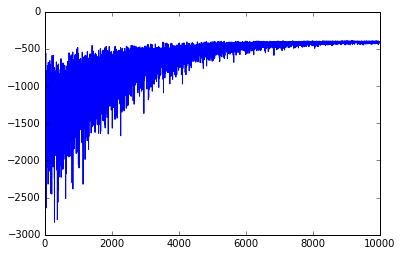

In [12]:
plt.plot(v_params.elbo_vals)

In [13]:
with training_model:
    advi_trace = variational.sample_vp(v_params, draws=5000)

In [ ]:
with training_model:
    # move the chain to the MAP which should be a good starting point
    #start = find_MAP()
    #step = NUTS()

    #trace = sample(3e3, step, start)
    
    step = NUTS(scaling=v_params.stds)

    nuts_trace = sample(8e3, step, start=v_params.means)


In [ ]:
traceplot(nuts_trace[1000:])

In [ ]:
summary(nuts_trace[1000:])

In [ ]:
alpha_a

In [ ]:
betas_a

In [ ]:
# Replace shared variables with testing set
model_input.set_value(X_test)
model_output.set_value(Y_test)

In [ ]:
# Create posterior predictive samples
ppc = sample_ppc(advi_trace, model=training_model, samples=1000)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [ ]:
print('ADVI Accuracy = {}%'.format((Y_test == pred).mean() * 100))

In [ ]:
# Create posterior predictive samples
ppc = sample_ppc(nuts_trace[1000:], model=training_model, samples=1000)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [ ]:
print('NUTS Accuracy = {}%'.format((Y_test == pred).mean() * 100))

API-ify a Model
===

In [81]:
API_test =  random.normal(size=(1, num_features))

In [82]:
API_Y_test = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * API_test, 1)))

In [83]:
API_Y_test

1

In [84]:
# Put in some fake data
API_fake_Y = 0

In [85]:
model_input = theano.shared(API_test)

In [86]:
API_model = Model()

with API_model:
    alpha = Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, num_features))
    
    #p = invlogit(alpha+T.dot(predictors, betas))
    p = invlogit(alpha + sum(betas*model_input, 1))

    #o = Bernoulli(b'o', p, shape=(1, 2))
    o = Bernoulli(b'o', p, observed=API_fake_Y)

In [87]:
# Create posterior predictive samples
ppc = sample_ppc(advi_trace, model=API_model, samples=1000)

In [88]:
# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [89]:
pred

array([ True], dtype=bool)

Hierachical Logistic Regression
===

In [ ]:
# Set up basic parameters
num_markets = 4

# Need lots of data to converge
num_per_market = 15000
num_observed = num_per_market * num_markets
num_features = 100

In [ ]:
# Set up markets
market = concatenate([[i] * num_per_market for i in range(num_markets)])

In [ ]:
market

In [ ]:
# Simulate the features
predictors = np.random.normal(size=(num_observed, num_features))

In [ ]:
alpha_a = np.random.normal(size=(num_markets))
beta_a = np.random.normal(size=(num_markets, num_features))

In [ ]:
# Calculate the actual data
p = alpha_a[market] + nsum(beta_a[market] * predictors, 1)

#p = nsum(beta_a[market] * predictors, 1)

In [ ]:
# Calculate the outcomes
outcomes = np.random.binomial(1, numpy_invlogit(p))

In [ ]:
model = Model()

with model:
    # Both alpha and beta are drawn for the same distributions
    mu_alpha = Normal(b"mu_alpha", 0, 100, shape=(1))
    sigma_alpha = Uniform(b"sigma_alpha", .0, 10, testval=2.)
    
    mu_beta = Normal(b"mu_beta", 0, 100, shape=(1))
    sigma_beta = Uniform(b"sigma_beta", 0, 10, testval=2.)
    
    alpha = Normal(b'alpha', mu=mu_alpha, tau=sigma_alpha, shape=(num_markets))
    beta = Normal(b'beta', mu=mu_beta, tau=sigma_beta, shape=(num_markets, num_features))
    
    m = T.constant(market)
#     print(alpha.random().shape)
#     print(beta.random().shape)
    p = tinvlogit(alpha[m] + sum(beta[m]*predictors, 1))
    #p = tinvlogit(alpha[m] + T.dot(predictors, beta[m, :]))
    #p = tinvlogit(sum(beta[m] * predictors, 1))
    
    o = Bernoulli(b'o', p, observed=outcomes)

In [ ]:
with model:
    v_params = variational.advi(n=10000)

In [ ]:
plt.plot(v_params.elbo_vals)

In [ ]:
mu

In [ ]:
sds

In [ ]:
with model:
    # move the chain to the MAP which should be a good starting point
    #start = find_MAP()
    #step = NUTS(scaling=start)
    #step = Slice()
#     step = NUTS()
#     trace = sample(3e4, step)
    
    step = NUTS(scaling=v_params.stds)
    trace = sample(20000, step, start=v_params.means)


In [ ]:
traceplot(trace)

In [ ]:
summary(trace)

In [ ]:
beta_a

In [ ]:
alpha_a

In [ ]:
mu['alpha']

In [ ]:
mu['beta']

In [ ]:
forestplot(trace, varnames=['mu_alpha', 'mu_beta', 'alpha', 'sigma_alpha', 'sigma_beta'])